This notebook contains a personnal study of naive bayes methods applied to classification problems.

Inspired from:
- https://scikit-learn.org/stable/modules/naive_bayes.html

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
print("Setup Complete")

Setup Complete


In [2]:
rng = np.random.RandomState(42)
print("Prayer to RNGesus Sent")

Prayer to RNGesus Sent


Let's create a synthetic dataset to play with. Here, we use the make_moons function for a nice 2-classes classification problem.

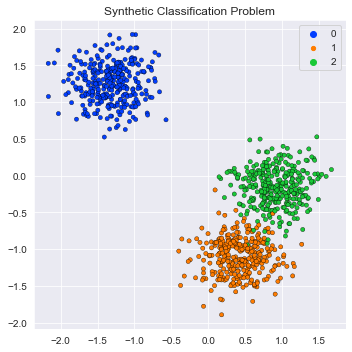

In [3]:
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler

# for plotting in 2D space
n_features = 2
columns = ['x', 'y']

# # moons
# X, y = make_moons(
#     n_samples=1000,
#     noise=0.3,
#     random_state=rng,
# )

# # circles
# X, y = make_circles(
#     n_samples=1000,
#     noise=0.1,
#     factor=0.5,
#     random_state=rng,
# )

# blobs
X, y = make_blobs(
    n_samples=1000, #random_state=rng,
    n_features=n_features
)


X = StandardScaler().fit_transform(X)
n_class = len(np.unique(y))

# visualization
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', ax=ax, size=1, edgecolor='k')
ax.set_title('Synthetic Classification Problem')
fig.tight_layout()
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

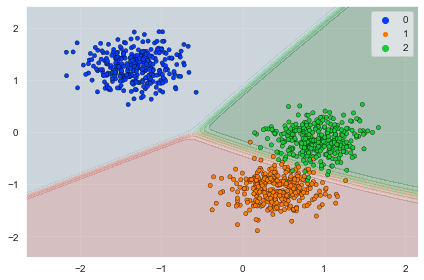

In [5]:
score = clf.score(X_test, y_test)

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(*xx.shape, -1)

fig, ax = plt.subplots()
# cm = plt.cm.RdBu
cm_list = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens,]
for i in range(n_class):
    ax.contourf(xx, yy, Z[..., i], cmap=cm_list[i], alpha=0.3)
# sns.kdeplot(x=X[:, 0], y=X[:, 1], hue=y, shade=True, alpha=0.5)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', ax=ax, size=1, edgecolor='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

fig.tight_layout()
plt.show()

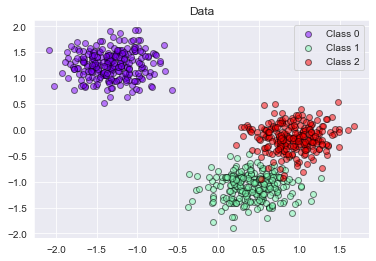

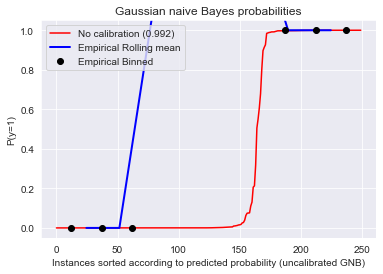

In [6]:
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % score)
# plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
#          label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
# plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
#          label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
# plt.plot(np.linspace(0, y_test.size, 51)[1::2],
#          y_test[order].reshape(25, -1).mean(axis=1),
#          'k', linewidth=3, label=r'Empirical')

from sklearn.isotonic import IsotonicRegression



x_range = np.arange(len(order))

# ir = IsotonicRegression(out_of_bounds="clip")
# y_ = ir.fit_transform(x_range, y_test[order])



# plt.plot(x_range, ir.predict(x_range),
#          'k', linewidth=3, label=r'Empirical')


kernel_size = 50
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(y_test[order], kernel, mode='valid')
x_convolved = np.convolve(x_range, kernel, mode='valid')

plt.plot(x_convolved, data_convolved,
         'b', linewidth=2, label=r'Empirical Rolling mean')


window_size = 10

plt.plot(x_range.reshape(window_size, -1).mean(axis=1),
         y_test[order].reshape(window_size, -1).mean(axis=1),
         'k', ls='none', marker='o', label=r'Empirical Binned')

plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

In [7]:
from sklearn.model_selection import learning_curve

from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=10, random_state=rng
)


train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    clf, X, y, cv=None,
    n_jobs=-1,
    return_times=True
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)


<module 'matplotlib.pyplot' from 'E:\\Projects\\Kaggle-Projects\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

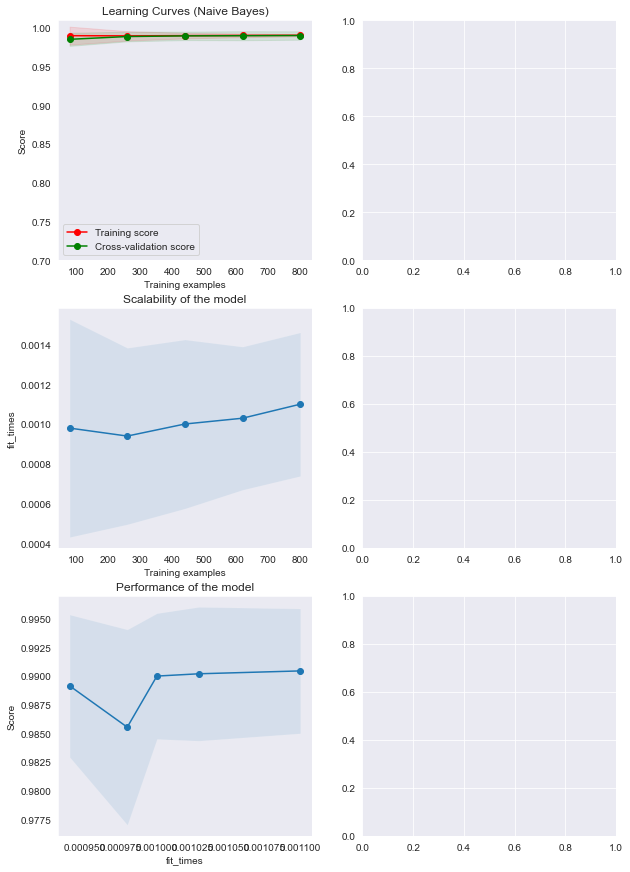

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    
    order = np.argsort(fit_times_mean)
    
    axes[2].plot(fit_times_mean[order], test_scores_mean[order], 'o-')
    axes[2].fill_between(fit_times_mean[order], test_scores_mean[order] - test_scores_std[order],
                         test_scores_mean[order] + test_scores_std[order], alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

from sklearn.model_selection import ShuffleSplit

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
